In [1]:
from keras.models import Sequential  # type: ignore
from keras.layers import Dense, Dropout, LSTM  # type: ignore
from keras.optimizers import RMSprop  # type: ignore
import numpy as np
import random
import sys


2025-05-19 22:05:56.305650: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-19 22:05:56.309407: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-19 22:05:56.319731: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747692356.339646   45699 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747692356.344094   45699 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747692356.361436   45699 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [3]:
filename = "Trading with Mexico.txt"
raw_text = open(filename, 'r', encoding='utf-8').read()
raw_text = raw_text.lower()
print(raw_text[0:1000])


the project gutenberg ebook of trading with mexico
    
this ebook is for the use of anyone anywhere in the united states and
most other parts of the world at no cost and with almost no restrictions
whatsoever. you may copy it, give it away or re-use it under the terms
of the project gutenberg license included with this ebook or online
at www.gutenberg.org. if you are not located in the united states,
you will have to check the laws of the country where you are located
before using this ebook.

title: trading with mexico

author: wallace thompson

release date: february 26, 2025 [ebook #75469]

language: english

original publication: new york: dodd, mead and company, 1921

credits: the online distributed proofreading team at https://www.pgdp.net (this file was produced from images generously made available by the internet archive)


*** start of the project gutenberg ebook trading with mexico ***





                              trading with
                                 mexico



In [4]:
raw_text = ''.join(c for c in raw_text if not c.isdigit())
chars = sorted(list(set(raw_text)))  # List of every character


In [5]:
char_to_int = dict((c, i) for i, c in enumerate(chars))
int_to_char = dict((i, c) for i, c in enumerate(chars))


In [6]:
n_chars = len(raw_text)
n_vocab = len(chars)
print("Total Characters in the text; corpus length: ", n_chars)
print("Total Vocab: ", n_vocab)


Total Characters in the text; corpus length:  387019
Total Vocab:  63


In [7]:
seq_length = 60  # Length of each input sequence
step = 10        # Instead of moving 1 letter at a time, try skipping a few.
sentences = []   # X values (Sentences)
next_chars = []  # Y values. The character that follows the sentence defined as X

for i in range(0, n_chars - seq_length, step):  # step=1 means each sentence is offset just by a single letter
    sentences.append(raw_text[i: i + seq_length])  # Sequence in
    next_chars.append(raw_text[i + seq_length])    # Sequence out

n_patterns = len(sentences)
print('Number of sequences:', n_patterns)


Number of sequences: 38696


In [8]:
x = np.zeros((len(sentences), seq_length, n_vocab), dtype=np.bool_)
y = np.zeros((len(sentences), n_vocab), dtype=np.bool_)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_to_int[char]] = 1
    y[i, char_to_int[next_chars[i]]] = 1

print(x.shape)
print(y.shape)
print(y[0:10])


(38696, 60, 63)
(38696, 63)
[[False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False  True False False False False False False False False False
  False False False False False False False False False False False False
  False False False]
 [False  True False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False Fals

In [9]:
model = Sequential()
model.add(LSTM(128, input_shape=(seq_length, n_vocab)))
model.add(Dense(n_vocab, activation='softmax'))

optimizer = RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)
model.summary()


2025-05-19 22:18:04.940623: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        98,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 63)             │         8,127 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 106,431 (415.75 KB)

 Trainable params: 106,431 (415.75 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# define the checkpoint
from keras.callbacks import ModelCheckpoint

filepath = "saved_weights-{epoch:02d}-{loss:.4f}.keras"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

callbacks_list = [checkpoint]


In [11]:
# Fit the model
history = model.fit(x, y,
                    batch_size=128,
                    epochs=50,
                    callbacks=callbacks_list)

model.save('my_saved_weights_50epochs.keras')


Epoch 1/50


2025-05-19 22:22:23.429672: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 146270880 exceeds 10% of free system memory.


302/303 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 2.7832
Epoch 1: loss improved from inf to 2.46960, saving model to saved_weights-01-2.4696.keras
303/303 ━━━━━━━━━━━━━━━━━━━━ 31s 98ms/step - loss: 2.7812
Epoch 2/50
302/303 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 2.0584
Epoch 2: loss improved from 2.46960 to 2.01550, saving model to saved_weights-02-2.0155.keras
303/303 ━━━━━━━━━━━━━━━━━━━━ 30s 98ms/step - loss: 2.0581
Epoch 3/50
302/303 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 1.8539
Epoch 3: loss improved from 2.01550 to 1.82964, saving model to saved_weights-03-1.8296.keras
303/303 ━━━━━━━━━━━━━━━━━━━━ 41s 97ms/step - loss: 1.8537
Epoch 4/50
302/303 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 1.6952
Epoch 4: loss improved from 1.82964 to 1.69485, saving model to saved_weights-04-1.6949.keras
303/303 ━━━━━━━━━━━━━━━━━━━━ 29s 97ms/step - loss: 1.6952
Epoch 5/50
302/303 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 1.5850
Epoch 5: loss improved from 1.69485 to 1.58921, saving model to sav

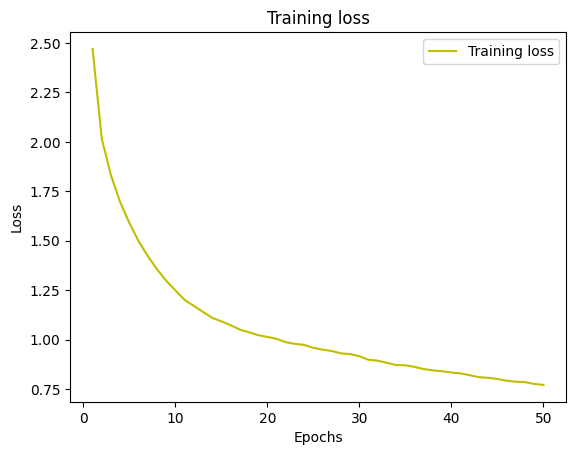

In [12]:
from matplotlib import pyplot as plt

#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [13]:
def sample(preds):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)  # exp of log(x), isn't this same as x??
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)


In [17]:
# Prediction
# load the network weights
filename = "saved_weights-50-0.7706.keras"
model.load_weights(filename)

#Pick a random sentence from the text as seed.
start_index = random.randint(0, n_chars - seq_length - 1)

#Initiate generated text and keep adding new predictions and print them out
generated = ''
sentence = raw_text[start_index: start_index + seq_length]
generated += sentence

print('----- Seed for our text prediction: "' + sentence + '"')
sys.stdout.write(generated)


----- Seed for our text prediction: "roleum.
the commercial struggle is to-day not the war for ma"
roleum.
the commercial struggle is to-day not the war for ma

60

In [19]:
for i in range(400):  # Number of characters including spaces
    x_pred = np.zeros((1, seq_length, n_vocab))
    for t, char in enumerate(sentence):
        x_pred[0, t, char_to_int[char]] = 1.

    preds = model.predict(x_pred, verbose=0)[0]
    next_index = sample(preds)
    next_char = int_to_char[next_index]

    generated += next_char
    sentence = sentence[1:] + next_char

    sys.stdout.write(next_char)
    sys.stdout.flush()
print()


re importeres destruction,
with the nome     thous of the totaces of the diaz agover muy gerates, on companies and nor unopsed for dried expenien business for only eages concest—ally “viblisg
mexican mexico ime part worth well compationa ineters, government from the hat,” .ely grownty with the prom age
vireuse, a dever yet the -create by the utherwere mexico’s as who as to uprus?t of the privame t
